In [1]:
#topic modeling and corpus creation
import spacy
nlp = spacy.load(r"C:\Users\conix\en_core_web_lg", exclude = ['NER','parse'])
from spacy.lang.en import STOP_WORDS
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from bertopic import BERTopic

#visulisation
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# standard packages
import pickle
import pandas as pd
import itertools as it
import numpy as np
import json
import string

# functions written for this in the MethodsCorpusFunctions.py file
from MethodsCorpusFunctions import view_methods, process_text, process_rawText, process_rawCorpus, create_dict, create_corpus, remove_ascii

# logging
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s",
                    level=logging.NOTSET)

# start with logging turned off 
logging.disable(logging.CRITICAL)

This notebook makes BERTopic and LDA models from the taxonomy methods (sections, paragraphs and sentences). The main aim of these topicmodels is to create a classification of taxonomic methods, and to select documents for labeling. 

In [3]:
## start by loading all the text created in the TM_IsolateMethods notebook

# the sections
with open('...\methods_rawtext.pickle', 'rb') as handle:
    methods_rawtext = pickle.load( handle)

# the paragraphs
filename = "...\methods_paragraph_corpus.pickle"
with open(filename, "rb") as f:
    methods_paras = pickle.load(f)

# the sentences
filename = "...\methods_sentencesrawtext.pickle"        
with open(filename, "rb") as f:
    methods_sentences = pickle.load(f)

# ids of all papers with method sections
filename = "...\methods_filenames.pickle"
with open(filename, "rb") as f:
    methods_filenames = pickle.load(f)

# Gensim LDA

## Phrase modeling

Start by making a bigram and trigram model to include bigrams and trigrams in our corpora. Since paragraphs are most likely the document-level of our choice, we use the paragraphs to make these models.

Note: a lot of the words that get picked up by the topic model as very specific for particular topics are bizarre trigrams (or even combinations of bigrams). I have to look into improving this, or just not model the trigrams?



In [42]:
# use spacy to process the paragraphs
# we lemmataize, remove punctuation and spaces, remove non-english words, and only keep certain types of words (eg no AUX)
# note: this takes about half an hour -- load the file below instead if you don't want to run

paras = list(methods_paras.values())
processed_paras = []
for para in tqdm(paras):
    processed_paras.append(' '.join(process_text(para)))
    

100%|██████████████████████████████████████████████████████████████████████████| 137598/137598 [25:47<00:00, 88.89it/s]


In [45]:
# write all paragraphs to a single text file with one paragraph per line
# this allows us to use genism's LineSentence

filename_processed_paras = '...\methods_paras_onefile.txt'
with open(filename_processed_paras, 'w', encoding = 'utf-8') as f:
    f.write("\n".join(map(str, processed_paras)))

In [48]:
## save the models here
bigram_model_filepath = "...\methods_bigram_model.txt"
trigram_model_filepath = "...\methods_trigram_model.txt"

## save the bigram and trigram text here
bigram_text_filepath = "...\methods_bigram_text.txt"
trigram_text_filepath = "...\methods_trigram_text.txt"

In [49]:
## make the bigram model using the processed text

unigram_text = LineSentence(filename_processed_paras)

# bigram model: make, save and load
bigram_model = Phrases(unigram_text)
bigram_model.save(bigram_model_filepath)
bigram_model = Phrases.load(bigram_model_filepath)

with open(bigram_text_filepath, 'a', encoding='utf_8') as f:
    
    for unigram_method in unigram_text:
        bigram_text = u' '.join(bigram_model[unigram_method])
        f.write(bigram_text + '\n')

bigram_text = LineSentence(bigram_text_filepath)

In [50]:
## make the trigram model using the processed text

trigram_model = Phrases(bigram_text)
trigram_model.save(trigram_model_filepath)
trigram_model = Phrases.load(trigram_model_filepath)


with open(trigram_text_filepath, 'w', encoding='utf_8') as f:
    
    for bigram_method in bigram_text:
        trigram_text = u' '.join(trigram_model[bigram_method])
        f.write(trigram_text + '\n')

trigram_text = LineSentence(trigram_text_filepath)

## Process the text at the section, paragraph and sentence level

There must be more efficient ways of doing this, and more successful ones too. The ngrams in the models don't seem to make much sense in most cases, so maybe better not to do this at all.

In [59]:
## we only have to process the corpus at the sentence-level and paragraph level. After that, we can combine lists of sentences/paragraphs to make the entire sections.
# again, this takes long so better to load the lists below

# sentences
processed_sentences = process_rawCorpus(list(methods_sentences.values()), bigram_model, trigram_model)

# # paragraphs
processed_paras = process_rawCorpus(paras, bigram_model, trigram_model)

100%|██████████████████████████████████████████████████████████████████████████| 137598/137598 [45:16<00:00, 50.65it/s]


In [60]:
# pickle these

filename = "...\methods_sentencesprocessed.pickle"        
with open(filename, 'wb') as handle:
    pickle.dump(processed_sentences, handle)

filename = "...\methods_parasprocessed.pickle"        
with open(filename, 'wb') as handle:
    pickle.dump(processed_paras, handle)

In [8]:
# now also get the processed sections by combining processed paragraphs

# dct of paragraph keys and processed paragraphs
processed_paras_dct = dict(zip(methods_paras.keys(), processed_paras))

# store processed sections
processed_sections = {}

# loop over sections, and combine all paragraphs from one section
for paper in methods_filenames:
    combined_paras = []
    for para_key in methods_paras.keys():
        if paper in para_key:
            combined_paras += processed_paras_dct[para_key]
    processed_sections[paper] = combined_paras   

filename = "...\methods_sectionsprocessed.pickle"        
with open(filename, 'wb') as handle:
    pickle.dump(processed_sections, handle)

In [13]:
# open the processed files

filename = "...\methods_sentencesprocessed.pickle"        
with open(filename, 'rb') as handle:
    processed_sentences = pickle.load(handle)

filename = "...\methods_parasprocessed.pickle"        
with open(filename, 'rb') as handle:
    processed_paras = pickle.load(handle)

filename = "...\methods_sectionsprocessed.pickle"        
with open(filename, 'rb') as handle:
    processed_sections = pickle.load(handle)

## Create gensim dictionaries and corpora

In [110]:
# write to single files in order to use LineSentence

filename_processed_paras2 = '...\methods_paras_onefile2.txt'
with open(filename_processed_paras2, 'w', encoding = 'utf-8') as f:
    f.write("\n".join(map(str, processed_paras)))

filename_processed_sentences = '...\methods_sentences_onefile.txt'
with open(filename_processed_sentences, 'w', encoding = 'utf-8') as f:
    f.write("\n".join(map(str, processed_sentences)))

filename_processed_sections = '...\methods_sections_onefile.txt'
with open(filename_processed_sections, 'w', encoding = 'utf-8') as f:
    f.write("\n".join(map(str, list(processed_sections.values()))))

In [10]:
## learn the dictionaries
## have to experiment with higher minimum occurence!!
sentences_dictionary = create_dict(processed_sentences, 'sentences',5,0.5)
paras_dictionary = create_dict(processed_paras,'paras',5,0.5)
sections_dictionary = create_dict(list(processed_sections.values()), 'sections',5,0.5)

# load the dictionaries if you don't want to make them yourself
sentences_dictionary = Dictionary.load("...\dict_sentences.dict")
paras_dictionary = Dictionary.load("...\dict_paras.dict")
sections_dictionary = Dictionary.load("...\dict_sections.dict")

## create the corpora

sentences_corpus = create_corpus(processed_sentences, sentences_dictionary, 'sentences')
paras_corpus = create_corpus(processed_paras, paras_dictionary, 'paras')
sections_corpus = create_corpus(list(processed_sections.values()), sections_dictionary, 'sections')

## load the corpora if you don't want to make them

sentences_corpus = MmCorpus("...\bow_sentences.mm")
paras_corpus = MmCorpus("...\bow_paras.mm")
sections_corpus = MmCorpus("...\bow_sections.mm")

## Training LDA Models

start by running multiple models for the paras corpus, to determine how many topics might be good


In [ ]:
logging.disable(logging.NOTSET)

corpus_size = len(methods_paras)
chunk_size = round(corpus_size, -3) + 1000

def model_for(num_topics):
  return LdaModel(
      corpus=paras_corpus,
      id2word=paras_dictionary,
      num_topics=num_topics,
      chunksize=chunk_size,
      update_every=1,
      iterations=150,
      passes=4,
      alpha="auto",
      eta="auto",
      random_state=1337
  )

# try these values for num_topics
NUM_TOPICS = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 50, 75, 100, 150]

# get the models, and store them in a dictionary
models = {}
for n in tqdm(NUM_TOPICS):
  models[n] = model_for(n)


# save the models

for num, model in models.items():
    model.save("...\ldaParas_" + f"{num}")


In [11]:
# load the models if you don't want to run the previous cell yourself

NUM_TOPICS = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 50, 75, 100, 150]
models = {}
for num in NUM_TOPICS:
    models[num] = LdaModel.load("...\ldaParas_" + f"{num}")

In [14]:
# Create a coherence model
cm = CoherenceModel.for_models(
    models.values(),
    paras_dictionary,
    corpus=paras_corpus,
    texts=processed_paras,
    coherence="c_v"
)
coherence_estimates = cm.compare_models(models.values())
coherences = dict(zip(models.keys(), coherence_estimates))

coherence_list = [(num_topics, avg_coherence)
  for num_topics, (_, avg_coherence) in coherences.items()]
ordered = sorted(coherence_list, key=lambda tup: tup[1], reverse=True)

print(f"Ranked by average '{cm.coherence}' coherence:\n")
for item in ordered:
  print("num_topics=%d:\t%.4f" % item)
print(f"\nBest: {ordered[0][0]}")

Ranked by average 'c_v' coherence:

num_topics=12:	0.6089
num_topics=10:	0.6084
num_topics=14:	0.6069
num_topics=20:	0.6064
num_topics=50:	0.6060
num_topics=8:	0.6034
num_topics=16:	0.6014
num_topics=6:	0.6001
num_topics=75:	0.5979
num_topics=22:	0.5972
num_topics=25:	0.5970
num_topics=18:	0.5967
num_topics=100:	0.5927
num_topics=150:	0.5797
num_topics=4:	0.5711

Best: 12


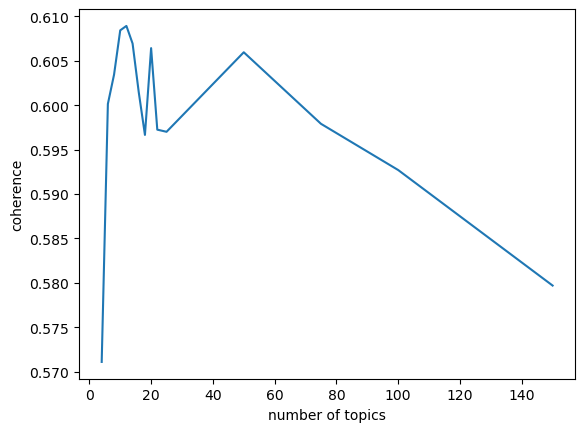

In [15]:
# Graph coherences
x_coords = [num_topics for num_topics, _ in coherences.items()]
y_coords = [c for _, (_, c) in coherences.items()]

plt.plot(x_coords, y_coords)
plt.xlabel("number of topics")
plt.ylabel("coherence")
plt.show()

Comparison of multiple models of the sections showed that up to 50 topics had good coherence scores, with 6 just a bit better. 5 passes and 150 iterations seemed enough. Given that we want to explore the corpus in a rather finegrained manner, and want to find as many methodological categories as possible to consider, we set the number of topics at 50.  Now (rather arbitrarily) get that number of topics for the sentences and sections as well.

In [44]:
# logging.disable(logging.NOTSET)

PASSES = 5
ITERATIONS = 150

# sentences

corpus_size = len(methods_sentences)
chunk_size = round(corpus_size, -3) + 1000

sentences_model = LdaModel(
    corpus=sentences_corpus,
    id2word=sentences_dictionary,
    num_topics=50,
    chunksize=chunk_size,
    iterations=ITERATIONS,
    passes=PASSES,
    alpha="auto",
    eta="auto",
    random_state=1337
)

sentences_model.save("...\ldaSentences")


# paragraphs

corpus_size = len(methods_paras)
chunk_size = round(corpus_size, -3) + 1000

paras_model = LdaModel(
    corpus=paras_corpus,
    id2word=paras_dictionary,
    num_topics=50,
    chunksize=chunk_size,
    iterations=ITERATIONS,
    passes=PASSES,
    alpha="auto",
    eta="auto",
    random_state=1337
)

paras_model.save("...\ldaParas")


# sections

corpus_size = len(methods_filenames)
chunk_size = round(corpus_size, -3) + 1000

sections_model = LdaModel(
    corpus=sections_corpus,
    id2word=sections_dictionary,
    num_topics=50,
    chunksize=chunk_size,
    iterations=ITERATIONS,
    passes=PASSES,
    alpha="auto",
    eta="auto",
    random_state=1337
)

sections_model.save("...\ldaSections")

# Turn logging back off again for later
logging.disable(logging.CRITICAL)

# BERTopic model

Try out transformer topic modeling. We use the very easy-to-use, well-documented package [BERTopic](https://maartengr.github.io/BERTopic/).

The main steps for topic modeling with BERTopic are sentence-transformers, UMAP (dimensionality reduction), HDBSCAN (clustering), and c-TF-IDF (identifying characteristic words) run in sequence. For more, see [here](https://maartengr.github.io/BERTopic/index.html). You can manually set hyperparameters for all steps, so I'll have to experiment more with this if we really want to use this more.

Bertopic topic models use BERT, and hence cannot have documents longer than 512 tokens. It also takes a lot longer than LDA if there are very many documents. Hence, we only get a BERTopic model for the paragraphs. Splitting up sections would not make sense, as paragraphs already do that in the (presumably) best possible way.

In [ ]:
# check tokens in sections and sentences
# if they are too long, the first 512 tokens get used.
# as long as there aren't too many of these, this should not matter

n_longsentences = np.sum(np.array([len(i.split(' ')) for i in methods_sentences.values()]) > 512)
n_longparas = np.sum(np.array([len(i.split(' ')) for i in methods_paras.values()]) > 512)

print(f"Proportion of sentences beyond the BERT limit: {n_longsentences / len(methods_sentences)}")
print(f"Proportion of paragraphs beyond the BERT limit: {n_longparas / len(methods_paras)}")

## Use default settings and transformer model of BERTopic

In [5]:
# try without preprocessing the text, only remove non-ascii characters
# preprocessing is not necessary as BERT needs context to get the meaning of words
# if the topics have too many auxiliaries and stop words, we can try an approach with preprocessing

# remove non ascii characters

clean_paras = remove_ascii(methods_paras)

# pickle the list

filename = "...\BERTopic_parasDocs.pickle"        
with open(filename, 'wb') as handle:
    pickle.dump(clean_paras, handle)

In [2]:
# make and save BERTopic model
logging.disable(logging.NOTSET)


BERTopic_paras = BERTopic(ngram_range = (1,3),
                          verbose=True,
                          calculate_probabilities=False) # set to True if you want topic probability by doc

# if you calculate probabilities, make this topics, probabilities = ...
topics, probabilities = BERTopic_paras.fit_transform(clean_paras) 

filepath = "...\BERTopic_paras"
BERTopic_paras.save(filepath)

In [39]:
len(list(methods_paras.values()))

137598

## Use the default settings with SciBERT as the transformer model

Scibert has been trained on a bunch of scientific paper abstracts, and might be better at understanding scientific text. Try it out, keeping the rest constant.

In [11]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("allenai/scibert_scivocab_uncased")

.gitattributes:   0%|          | 0.00/437 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:
# get the embeddings and save them separately so we can reuse them
# this is the step that takes most time (12 hours on my laptop!)

embeddings = sentence_model.encode(list(methods_paras.values()), show_progress_bar=True)
# np.save('...\scibert_paras_embeddings.npy', embeddings)


In [ ]:
embeddings = np.load('...\scibert_paras_embeddings.npy')


In [34]:
from umap import UMAP
from bertopic import BERTopic
from sklearn.decomposition import PCA

# another time consuming step is the umap. You can speed this up by rescaling the embeddings we saved above and feeding them into the umap model. I haven't looked into the details of this, but it is a bit faster indeed.

def rescale(x, inplace=False):
    """ 
    Rescale an embedding so optimization will not have convergence issues.
    
    """
    if not inplace:
        x = np.array(x, copy=True)

    x /= np.std(x[:, 0]) * 10000

    return x



# Initialize and rescale PCA embeddings
pca_embeddings = rescale(PCA(n_components=5).fit_transform(embeddings))




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Start UMAP from PCA embeddings
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    init=pca_embeddings,
    random_state = 42)

# the model didn't work well at all without removing stopwords, so do that too
vectorizer_model = CountVectorizer(stop_words = 'english',
                                   ngram_range=(1, 2), # include unigrams and bigrams
                                   min_df=10, #minimim frequency of docs with a token
                                   max_df=0.95) # max frequency of docs with a token

    

In [37]:
# add the umap_model and vectorizer model from above, and initiate the model 

BERTopic_paras_scibert = BERTopic( umap_model = umap_model,
                        vectorizer_model = vectorizer_model,
                       low_memory=False, # faster when False
                       verbose=True,
                       embedding_model=sentence_model,
                       nr_topics="auto",
                       calculate_probabilities=False,
                        )

topics, probabilities = BERTopic_paras_scibert.fit_transform(list(methods_paras.values()),embeddings)

filepath = "...\BERTopic_paras_scibert"
BERTopic_paras_scibert.save(filepath)

## To do: Use SciBERT and tune other hyperparameters.

You can manually set the hyperparameters for all steps in the BERTopic process. More info [here](https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html). The default settings with the default model were already pretty informative, so haven't really tested this. I have tried a few pretty random runs, but didn't get any particularly informative models. 

Note: with the precalculated embeddings the modelling is pretty fast, so easy to test. Moreover, you can use update_topics to change things like the vectorizer_model, the ngram_range, or what you do with the stopwords (see [here](https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.update_topics)).

In [17]:
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
import hdbscan

# manually set parameters for dimensionality reduction
# probably better not to touch this one

umap_model = UMAP(n_neighbors=15, # smaller is a more local view, larger is more global and larger clusters
                  n_components=7, #set dimensionality of embeddings after reducing them. trade-off between keeping information and keeping clustering easy for hdbscan
                  metric='cosine', # metric to compute distances
                  low_memory=False,
                 random_state=42) # preventing stochastic behaviour

# you can manually choose the parameters for the clustering

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=150, # granularity of clustering, best way to control n topics.
                                min_samples=5, # number of neighbours to be a core part of a cluster
                                metric='euclidean', # how to calculate the distances
                         prediction_data=False) # change if we want to classify new datapoints

# too much preprocessing is not good because the transformer model needs the context, but it is possible to preprocess documents after having generated embeddings and clustering documents using countvectorizer

vectorizer_model = CountVectorizer(stop_words = 'english',
                                   ngram_range=(1, 2), # include unigrams and bigrams
                                   min_df=5, #minimim frequency of docs with a token
                                   max_df=1.0) # max frequency of docs with a token


# Use a KeyBert inspired model to improve the topic representation (this also reduces stop words in the topic representation)
# for more, see here: https://maartengr.github.io/KeyBERT/
representation_model = KeyBERTInspired()

In [ ]:

# Then train the topic model using these pre-trained embeddings
# put this in a loop to try different hyperparameter values. 

BERTopic_paras_scibert_tune = BERTopic(umap_model = umap_model,
                        hdbscan_model=hdbscan_model,
                       low_memory=True,
                       verbose=True, # show progress bar
                        top_n_words=10, 
                       embedding_model=sentence_model,
                       nr_topics="auto", # you can force a number, but is not recommended
                       vectorizer_model=vectorizer_model,
                       min_topic_size = 100,# only accept topics with a certain number of docs
                      representation_model=representation_model,
                       calculate_probabilities=False) # computationally expensive

# use the same embeddings as in the previous model -- this saves a lot of time
topics, probabilities = BERTopic_paras_scibert_tune.fit_transform(list(methods_paras.values()), embeddings)

filepath = "...\BERTopic_paras_complex_tune"
BERTopic_paras_scibert.save(filepath)

## Bertopic coherence scores

The main developer seems to think that it's generally not a good idea to use coherence scores to tune the parameters of the model, so I haven't really do this for now. There also seem to be very many possible metrics, and I'd have to look into this if we do want to use it. In anyway, it is possible to use gensim and get the coherence scores like we did for the LDA models. I don't think we can meaningfully compare them (the preprocessing of the corpus was very different), but I add the code here in case we want to develop this later or just to get an idea of coherence scores. For more on coherence of bertopic models, see [here](https://github.com/MaartenGr/BERTopic/issues/90) (this is also where I took the code below from).

In [56]:
# Preprocess Documents

docs = list(methods_paras.values())

documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics[0]})

documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = BERTopic_paras_scibert._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics[0]))-1)]


In [2]:
# Evaluate, can take a while
# nevermind, takes way too long on my laptop
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()